In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
np.random.seed(0)

In [3]:
decoder = tf.keras.models.load_model('../models/decoderJLA.h5')
autoencoder = tf.keras.models.load_model('../models/autoencoderJLA.h5')
encoder = tf.keras.models.load_model('../models/encoderJLA.h5')
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))

In [4]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
errors = np.sqrt(np.abs(np.diagonal(syscov)))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.001 * err

split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))

encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)

 Generating 1000 matrix 

In [5]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

dataa = data.values[shuffle]
z = dataa[:,0]
dl = dataa[:,1:]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))




# FFNN

In [6]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)



In [7]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
#     x = MCDropout(0.02)(efirst)
    x = Dense(50, activation='relu')(efirst)
    x = MCDropout(0.02)(x)
    x = Dense(50, activation='relu')(x)
#     x = MCDropout(0.02)(x)
    x = Dense(30, activation='relu')(x)
#     x = MCDropout(0.02)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [8]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=1,
                                    epochs=5000,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/5000
24/24 [==============================] - 0s 7ms/step - loss: 1425.3524 - val_loss: 1709.8724
Epoch 2/5000
24/24 [==============================] - 0s 1ms/step - loss: 1342.7850 - val_loss: 1596.7776
Epoch 3/5000
24/24 [==============================] - 0s 1ms/step - loss: 1053.7588 - val_loss: 1182.5192
Epoch 4/5000
24/24 [==============================] - 0s 1ms/step - loss: 421.9580 - val_loss: 389.3874
Epoch 5/5000
24/24 [==============================] - 0s 1ms/step - loss: 120.9707 - val_loss: 184.1174
Epoch 6/5000
24/24 [==============================] - 0s 2ms/step - loss: 81.1710 - val_loss: 136.3738
Epoch 7/5000
24/24 [==============================] - 0s 1ms/step - loss: 71.0518 - val_loss: 120.9013
Epoch 8/5000
24/24 [==============================] - 0s 1ms/step - loss: 44.5158 - val_loss: 91.4064
Epoch 9/5000
24/24 [==============================] - 0s 1ms/step - loss: 43.4305 - val_loss: 84.4761
Epoch 10/5000
24/24 [==============================] - 0s 1ms/st

24/24 [==============================] - 0s 1ms/step - loss: 2.0745 - val_loss: 0.4394
Epoch 82/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.9036 - val_loss: 1.4146
Epoch 83/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.5155 - val_loss: 2.2388
Epoch 84/5000
24/24 [==============================] - 0s 1ms/step - loss: 3.3781 - val_loss: 1.4733
Epoch 85/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.8063 - val_loss: 1.2783
Epoch 86/5000
24/24 [==============================] - 0s 1ms/step - loss: 3.7530 - val_loss: 0.6508
Epoch 87/5000
24/24 [==============================] - 0s 2ms/step - loss: 2.3973 - val_loss: 0.5026
Epoch 88/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.9408 - val_loss: 1.8196
Epoch 89/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.0721 - val_loss: 2.0253
Epoch 90/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.8668 - val_loss: 3.7801
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 1.8923 - val_loss: 1.8260
Epoch 162/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.3433 - val_loss: 3.2643
Epoch 163/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.5824 - val_loss: 2.3625
Epoch 164/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.7883 - val_loss: 1.3887
Epoch 165/5000
24/24 [==============================] - 0s 2ms/step - loss: 2.3479 - val_loss: 1.9193
Epoch 166/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0078 - val_loss: 0.9976
Epoch 167/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.3055 - val_loss: 0.5261
Epoch 168/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.4743 - val_loss: 4.9479
Epoch 169/5000
24/24 [==============================] - 0s 1ms/step - loss: 3.0121 - val_loss: 1.1906
Epoch 170/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.1051 - val_loss: 2.

24/24 [==============================] - 0s 2ms/step - loss: 1.7703 - val_loss: 0.7266
Epoch 242/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0585 - val_loss: 1.7038
Epoch 243/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.8822 - val_loss: 1.0816
Epoch 244/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.1036 - val_loss: 2.2854
Epoch 245/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.7051 - val_loss: 0.4849
Epoch 246/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.6804 - val_loss: 1.1614
Epoch 247/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.5365 - val_loss: 0.2433
Epoch 248/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.1918 - val_loss: 1.1191
Epoch 249/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.3335 - val_loss: 1.9905
Epoch 250/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.3887 - val_loss: 4.

24/24 [==============================] - 0s 1ms/step - loss: 0.8910 - val_loss: 0.8354
Epoch 322/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.3534 - val_loss: 0.7481
Epoch 323/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.2187 - val_loss: 1.5333
Epoch 324/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0579 - val_loss: 1.0109
Epoch 325/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.1682 - val_loss: 7.6591
Epoch 326/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.9552 - val_loss: 2.4788
Epoch 327/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.5055 - val_loss: 0.8924
Epoch 328/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.6879 - val_loss: 1.8425
Epoch 329/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.4476 - val_loss: 2.8766
Epoch 330/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.5046 - val_loss: 3.

24/24 [==============================] - 0s 2ms/step - loss: 1.8952 - val_loss: 2.9042
Epoch 402/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.4602 - val_loss: 2.5190
Epoch 403/5000
24/24 [==============================] - 0s 1ms/step - loss: 3.5594 - val_loss: 0.5808
Epoch 404/5000
24/24 [==============================] - 0s 1ms/step - loss: 2.2162 - val_loss: 0.7658
Epoch 405/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.7239 - val_loss: 0.7438
Epoch 406/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7499 - val_loss: 1.3058
Epoch 407/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.6616 - val_loss: 1.7805
Epoch 408/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.8942 - val_loss: 3.3727
Epoch 409/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.6716 - val_loss: 1.2217
Epoch 410/5000
24/24 [==============================] - 0s 2ms/step - loss: 2.0377 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 1.0936 - val_loss: 0.7575
Epoch 482/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.6447 - val_loss: 0.8012
Epoch 483/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.6553 - val_loss: 1.2444
Epoch 484/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4677 - val_loss: 0.5656
Epoch 485/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.6351 - val_loss: 1.6630
Epoch 486/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.3904 - val_loss: 2.3582
Epoch 487/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.4280 - val_loss: 0.9115
Epoch 488/5000
24/24 [==============================] - 0s 3ms/step - loss: 1.2961 - val_loss: 0.4849
Epoch 489/5000
24/24 [==============================] - 0s 2ms/step - loss: 2.2009 - val_loss: 2.1546
Epoch 490/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.1384 - val_loss: 1.

24/24 [==============================] - 0s 1ms/step - loss: 1.1778 - val_loss: 3.6406
Epoch 562/5000
24/24 [==============================] - 0s 2ms/step - loss: 2.7224 - val_loss: 0.6213
Epoch 563/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.6024 - val_loss: 3.3056
Epoch 564/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.6531 - val_loss: 0.4821
Epoch 565/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3077 - val_loss: 0.1911
Epoch 566/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7169 - val_loss: 0.5529
Epoch 567/5000
24/24 [==============================] - 0s 1ms/step - loss: 1.1687 - val_loss: 0.3417
Epoch 568/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.3996 - val_loss: 1.5661
Epoch 569/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0997 - val_loss: 2.0272
Epoch 570/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.8481 - val_loss: 1.

24/24 [==============================] - 0s 2ms/step - loss: 0.9431 - val_loss: 0.1603
Epoch 642/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7571 - val_loss: 0.5930
Epoch 643/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4206 - val_loss: 0.4388
Epoch 644/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.5851 - val_loss: 1.8718
Epoch 645/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.8422 - val_loss: 2.2566
Epoch 646/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.3380 - val_loss: 0.6714
Epoch 647/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.8987 - val_loss: 1.1371
Epoch 648/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0092 - val_loss: 1.3161
Epoch 649/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.6447 - val_loss: 0.4260
Epoch 650/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5547 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 0.7136 - val_loss: 1.7736
Epoch 722/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.3678 - val_loss: 1.0738
Epoch 723/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.6215 - val_loss: 1.1325
Epoch 724/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7933 - val_loss: 2.3222
Epoch 725/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0006 - val_loss: 2.4838
Epoch 726/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.8047 - val_loss: 1.1537
Epoch 727/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4789 - val_loss: 0.1736
Epoch 728/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.8381 - val_loss: 0.1198
Epoch 729/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4923 - val_loss: 1.1084
Epoch 730/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.8113 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 0.3966 - val_loss: 0.2732
Epoch 802/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.1752 - val_loss: 0.4323
Epoch 803/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.2235 - val_loss: 3.0400
Epoch 804/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.2682 - val_loss: 3.0105
Epoch 805/5000
24/24 [==============================] - 0s 2ms/step - loss: 3.9123 - val_loss: 7.2191
Epoch 806/5000
24/24 [==============================] - 0s 2ms/step - loss: 2.5890 - val_loss: 2.4623
Epoch 807/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.9884 - val_loss: 1.9998
Epoch 808/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.2341 - val_loss: 0.2027
Epoch 809/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5255 - val_loss: 2.0524
Epoch 810/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.8214 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 0.6049 - val_loss: 0.1485
Epoch 882/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7348 - val_loss: 0.4487
Epoch 883/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.1856 - val_loss: 2.2550
Epoch 884/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.0277 - val_loss: 0.8498
Epoch 885/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4666 - val_loss: 0.2549
Epoch 886/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4164 - val_loss: 0.4797
Epoch 887/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7305 - val_loss: 1.9312
Epoch 888/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7975 - val_loss: 0.4265
Epoch 889/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3926 - val_loss: 0.5800
Epoch 890/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.4435 - val_loss: 0.

24/24 [==============================] - 0s 2ms/step - loss: 0.7616 - val_loss: 1.4231
Epoch 962/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.1209 - val_loss: 1.7841
Epoch 963/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3801 - val_loss: 0.0411
Epoch 964/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2204 - val_loss: 0.5746
Epoch 965/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3637 - val_loss: 0.1632
Epoch 966/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2000 - val_loss: 0.1426
Epoch 967/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3407 - val_loss: 0.6647
Epoch 968/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4625 - val_loss: 0.4473
Epoch 969/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3372 - val_loss: 0.6259
Epoch 970/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3119 - val_loss: 0.

24/24 [==============================] - 0s 3ms/step - loss: 0.7197 - val_loss: 0.8728
Epoch 1042/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.4689 - val_loss: 1.0437
Epoch 1043/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7031 - val_loss: 0.1638
Epoch 1044/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.2227 - val_loss: 0.2442
Epoch 1045/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.2870 - val_loss: 1.1056
Epoch 1046/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.4232 - val_loss: 0.3958
Epoch 1047/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.2784 - val_loss: 0.7571
Epoch 1048/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3621 - val_loss: 1.3288
Epoch 1049/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.7516 - val_loss: 0.1861
Epoch 1050/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.4705 - val

24/24 [==============================] - 0s 3ms/step - loss: 0.2726 - val_loss: 0.8516
Epoch 1121/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.3290 - val_loss: 0.3864
Epoch 1122/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2748 - val_loss: 0.4954
Epoch 1123/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1591 - val_loss: 0.3174
Epoch 1124/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.3268 - val_loss: 0.2552
Epoch 1125/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4198 - val_loss: 0.4485
Epoch 1126/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.3497 - val_loss: 0.8623
Epoch 1127/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.4942 - val_loss: 0.3962
Epoch 1128/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.2451 - val_loss: 0.5623
Epoch 1129/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.4552 - val

24/24 [==============================] - 0s 3ms/step - loss: 0.4086 - val_loss: 0.2915
Epoch 1200/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.9445 - val_loss: 0.4538
Epoch 1201/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2803 - val_loss: 0.5778
Epoch 1202/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5758 - val_loss: 0.0499
Epoch 1203/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2263 - val_loss: 0.2176
Epoch 1204/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3947 - val_loss: 0.2138
Epoch 1205/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3306 - val_loss: 0.6876
Epoch 1206/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4622 - val_loss: 0.7375
Epoch 1207/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1608 - val_loss: 0.2393
Epoch 1208/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.2098 - val

24/24 [==============================] - 0s 2ms/step - loss: 3.1463 - val_loss: 0.6610
Epoch 1279/5000
24/24 [==============================] - 0s 2ms/step - loss: 1.3239 - val_loss: 1.4186
Epoch 1280/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7516 - val_loss: 0.4328
Epoch 1281/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.7676 - val_loss: 0.3016
Epoch 1282/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.4405 - val_loss: 0.5645
Epoch 1283/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3751 - val_loss: 0.0676
Epoch 1284/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2435 - val_loss: 0.1459
Epoch 1285/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5147 - val_loss: 0.8187
Epoch 1286/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5348 - val_loss: 0.5262
Epoch 1287/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4867 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.2045 - val_loss: 0.9694
Epoch 1358/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.3268 - val_loss: 0.2879
Epoch 1359/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.5014 - val_loss: 0.1243
Epoch 1360/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.3222 - val_loss: 0.7323
Epoch 1361/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1959 - val_loss: 0.1907
Epoch 1362/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1992 - val_loss: 0.0830
Epoch 1363/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1770 - val_loss: 0.0418
Epoch 1364/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2143 - val_loss: 0.2956
Epoch 1365/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2027 - val_loss: 0.1106
Epoch 1366/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1400 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.2116 - val_loss: 0.3400
Epoch 1437/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1240 - val_loss: 0.1285
Epoch 1438/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1402 - val_loss: 0.1727
Epoch 1439/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2410 - val_loss: 0.0705
Epoch 1440/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2925 - val_loss: 0.4187
Epoch 1441/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1873 - val_loss: 0.3705
Epoch 1442/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1507 - val_loss: 0.1626
Epoch 1443/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5945 - val_loss: 1.1784
Epoch 1444/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3440 - val_loss: 0.2289
Epoch 1445/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5199 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.1907 - val_loss: 0.0636
Epoch 1516/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1693 - val_loss: 0.1119
Epoch 1517/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1715 - val_loss: 0.1973
Epoch 1518/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1889 - val_loss: 0.1359
Epoch 1519/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1287 - val_loss: 0.3737
Epoch 1520/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2228 - val_loss: 0.4403
Epoch 1521/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3289 - val_loss: 0.4752
Epoch 1522/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1933 - val_loss: 0.1202
Epoch 1523/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1430 - val_loss: 0.2089
Epoch 1524/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4225 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.4720 - val_loss: 0.0971
Epoch 1595/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.6223 - val_loss: 0.6989
Epoch 1596/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3598 - val_loss: 0.1782
Epoch 1597/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1598 - val_loss: 0.3034
Epoch 1598/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1117 - val_loss: 0.0389
Epoch 1599/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2193 - val_loss: 0.2014
Epoch 1600/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2567 - val_loss: 0.1835
Epoch 1601/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2683 - val_loss: 0.0981
Epoch 1602/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2704 - val_loss: 0.5815
Epoch 1603/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1784 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.1238 - val_loss: 0.1090
Epoch 1674/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1355 - val_loss: 0.1019
Epoch 1675/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1461 - val_loss: 0.1546
Epoch 1676/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.3145 - val_loss: 0.7741
Epoch 1677/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.5096 - val_loss: 0.3696
Epoch 1678/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2482 - val_loss: 0.0614
Epoch 1679/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.3735 - val_loss: 0.1108
Epoch 1680/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1953 - val_loss: 0.3373
Epoch 1681/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1439 - val_loss: 0.0399
Epoch 1682/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0697 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0367
Epoch 1753/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.3042 - val_loss: 0.1829
Epoch 1754/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2848 - val_loss: 0.3315
Epoch 1755/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2066 - val_loss: 0.3924
Epoch 1756/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2323 - val_loss: 0.1578
Epoch 1757/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2461 - val_loss: 0.1292
Epoch 1758/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2741 - val_loss: 0.1655
Epoch 1759/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1460 - val_loss: 0.1598
Epoch 1760/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2374 - val_loss: 0.0831
Epoch 1761/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1018 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.2803 - val_loss: 0.1101
Epoch 1832/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0840 - val_loss: 0.0991
Epoch 1833/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1453 - val_loss: 0.2814
Epoch 1834/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1081 - val_loss: 0.2450
Epoch 1835/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1184 - val_loss: 0.0574
Epoch 1836/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1133 - val_loss: 0.1773
Epoch 1837/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2659 - val_loss: 0.1216
Epoch 1838/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0459
Epoch 1839/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.2168
Epoch 1840/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1119 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.1042 - val_loss: 0.2039
Epoch 1911/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2272 - val_loss: 0.0228
Epoch 1912/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1598 - val_loss: 0.3059
Epoch 1913/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1444 - val_loss: 0.3169
Epoch 1914/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0878 - val_loss: 0.0462
Epoch 1915/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2064 - val_loss: 0.6878
Epoch 1916/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1663 - val_loss: 0.0477
Epoch 1917/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1229 - val_loss: 0.0443
Epoch 1918/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0804
Epoch 1919/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0802 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.2034 - val_loss: 0.0787
Epoch 1990/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1143 - val_loss: 0.2598
Epoch 1991/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0937 - val_loss: 0.1424
Epoch 1992/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1452 - val_loss: 0.1097
Epoch 1993/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0856 - val_loss: 0.3552
Epoch 1994/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1401 - val_loss: 0.2025
Epoch 1995/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0357
Epoch 1996/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1503 - val_loss: 0.1808
Epoch 1997/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1958 - val_loss: 0.0485
Epoch 1998/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3799 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0454
Epoch 2069/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0786 - val_loss: 0.0280
Epoch 2070/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0182
Epoch 2071/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0841 - val_loss: 0.0749
Epoch 2072/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1620 - val_loss: 0.2740
Epoch 2073/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1269 - val_loss: 0.1777
Epoch 2074/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3415 - val_loss: 0.0618
Epoch 2075/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0871 - val_loss: 0.0242
Epoch 2076/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1783 - val_loss: 0.5174
Epoch 2077/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1824 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.2541
Epoch 2148/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0874 - val_loss: 0.5828
Epoch 2149/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1521 - val_loss: 0.5377
Epoch 2150/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1820 - val_loss: 0.1583
Epoch 2151/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2290 - val_loss: 0.2250
Epoch 2152/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1648 - val_loss: 0.0261
Epoch 2153/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1265 - val_loss: 0.1940
Epoch 2154/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1384 - val_loss: 0.2359
Epoch 2155/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1282 - val_loss: 0.4229
Epoch 2156/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1700 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.2078 - val_loss: 0.1719
Epoch 2227/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0982 - val_loss: 0.1962
Epoch 2228/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.1140
Epoch 2229/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1416 - val_loss: 0.0957
Epoch 2230/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1471 - val_loss: 0.1357
Epoch 2231/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1438 - val_loss: 0.0684
Epoch 2232/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1960 - val_loss: 0.0725
Epoch 2233/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1353 - val_loss: 0.5220
Epoch 2234/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.1440
Epoch 2235/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1532 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.3326 - val_loss: 0.2306
Epoch 2306/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0916 - val_loss: 0.0750
Epoch 2307/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1007 - val_loss: 0.0929
Epoch 2308/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1196 - val_loss: 0.1732
Epoch 2309/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.6887
Epoch 2310/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1971 - val_loss: 0.6571
Epoch 2311/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3015 - val_loss: 0.1821
Epoch 2312/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1210 - val_loss: 0.1909
Epoch 2313/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.2189
Epoch 2314/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0844 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0394
Epoch 2385/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.6747
Epoch 2386/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1219 - val_loss: 0.0689
Epoch 2387/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1879 - val_loss: 0.2648
Epoch 2388/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1024 - val_loss: 0.0197
Epoch 2389/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3051 - val_loss: 0.8078
Epoch 2390/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1544 - val_loss: 0.0172
Epoch 2391/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1087 - val_loss: 0.2324
Epoch 2392/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1959 - val_loss: 0.0591
Epoch 2393/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1921 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.1776
Epoch 2464/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1153 - val_loss: 0.0870
Epoch 2465/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0897 - val_loss: 0.1570
Epoch 2466/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1168 - val_loss: 0.1878
Epoch 2467/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0714
Epoch 2468/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0355
Epoch 2469/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.2858
Epoch 2470/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1649 - val_loss: 0.0827
Epoch 2471/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1911 - val_loss: 0.2053
Epoch 2472/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1013 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.2442 - val_loss: 0.1525
Epoch 2543/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3653 - val_loss: 0.0971
Epoch 2544/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1898 - val_loss: 0.1577
Epoch 2545/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1102 - val_loss: 0.1705
Epoch 2546/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1887 - val_loss: 0.2726
Epoch 2547/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1958 - val_loss: 0.0863
Epoch 2548/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2500 - val_loss: 0.0665
Epoch 2549/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1203 - val_loss: 0.0785
Epoch 2550/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.1725
Epoch 2551/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1446 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.2134 - val_loss: 0.0327
Epoch 2622/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1565 - val_loss: 0.0689
Epoch 2623/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.1070
Epoch 2624/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.2085 - val_loss: 0.1230
Epoch 2625/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.5042 - val_loss: 0.2890
Epoch 2626/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1273 - val_loss: 0.0422
Epoch 2627/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.3741
Epoch 2628/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1016 - val_loss: 0.1390
Epoch 2629/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1010 - val_loss: 0.0776
Epoch 2630/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0881 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0819 - val_loss: 0.0740
Epoch 2701/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1104 - val_loss: 2.2416
Epoch 2702/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.3275 - val_loss: 0.5817
Epoch 2703/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.4938 - val_loss: 0.1318
Epoch 2704/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1489 - val_loss: 0.1197
Epoch 2705/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.1048
Epoch 2706/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.2814
Epoch 2707/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.1873
Epoch 2708/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1077 - val_loss: 0.1470
Epoch 2709/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1140 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0907 - val_loss: 0.0973
Epoch 2780/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0462 - val_loss: 0.0792
Epoch 2781/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.1300
Epoch 2782/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0485
Epoch 2783/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0947 - val_loss: 0.1722
Epoch 2784/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.1295
Epoch 2785/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1267 - val_loss: 0.1442
Epoch 2786/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1307 - val_loss: 0.0536
Epoch 2787/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1279 - val_loss: 0.0468
Epoch 2788/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1051 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0563 - val_loss: 0.0711
Epoch 2859/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1055 - val_loss: 0.2044
Epoch 2860/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0785
Epoch 2861/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0400
Epoch 2862/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0826 - val_loss: 0.1978
Epoch 2863/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0927
Epoch 2864/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1128 - val_loss: 0.1932
Epoch 2865/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1441 - val_loss: 0.1567
Epoch 2866/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1340 - val_loss: 0.0735
Epoch 2867/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0764 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0744 - val_loss: 0.0518
Epoch 2938/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1476 - val_loss: 0.0352
Epoch 2939/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1406 - val_loss: 0.1170
Epoch 2940/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0550
Epoch 2941/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0463 - val_loss: 0.0575
Epoch 2942/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.3591
Epoch 2943/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.1812
Epoch 2944/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0974 - val_loss: 0.3680
Epoch 2945/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1260 - val_loss: 0.0464
Epoch 2946/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0572 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0887 - val_loss: 0.0412
Epoch 3017/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0747
Epoch 3018/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.2398
Epoch 3019/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1753 - val_loss: 0.1190
Epoch 3020/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1733 - val_loss: 0.1820
Epoch 3021/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1046 - val_loss: 0.0778
Epoch 3022/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1141 - val_loss: 0.3378
Epoch 3023/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.2914
Epoch 3024/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0462
Epoch 3025/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1723 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0513
Epoch 3096/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0480 - val_loss: 0.0805
Epoch 3097/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.0416
Epoch 3098/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0789 - val_loss: 0.0614
Epoch 3099/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0530 - val_loss: 0.0769
Epoch 3100/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0917 - val_loss: 0.3048
Epoch 3101/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1388 - val_loss: 0.1396
Epoch 3102/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1045 - val_loss: 0.0546
Epoch 3103/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1244 - val_loss: 0.2228
Epoch 3104/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1340 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0327
Epoch 3175/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1042 - val_loss: 0.2156
Epoch 3176/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1059 - val_loss: 0.2271
Epoch 3177/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0831 - val_loss: 0.0118
Epoch 3178/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0476 - val_loss: 0.2666
Epoch 3179/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1218 - val_loss: 0.2385
Epoch 3180/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1217 - val_loss: 0.4614
Epoch 3181/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0847 - val_loss: 0.0658
Epoch 3182/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0800 - val_loss: 0.0758
Epoch 3183/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2361 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0460 - val_loss: 0.0317
Epoch 3254/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0858 - val_loss: 0.0285
Epoch 3255/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0796 - val_loss: 0.0783
Epoch 3256/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1003 - val_loss: 0.0719
Epoch 3257/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1288 - val_loss: 0.1047
Epoch 3258/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1373 - val_loss: 0.0645
Epoch 3259/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0741 - val_loss: 0.1899
Epoch 3260/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0741 - val_loss: 0.0418
Epoch 3261/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0677
Epoch 3262/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0443 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0996 - val_loss: 0.2763
Epoch 3333/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1550 - val_loss: 0.1802
Epoch 3334/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1643 - val_loss: 0.4109
Epoch 3335/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0467 - val_loss: 0.0232
Epoch 3336/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0479 - val_loss: 0.2986
Epoch 3337/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0930
Epoch 3338/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0949
Epoch 3339/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.2336
Epoch 3340/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0759 - val_loss: 0.0416
Epoch 3341/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0680 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.1061 - val_loss: 0.0554
Epoch 3412/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1367 - val_loss: 0.4039
Epoch 3413/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1619 - val_loss: 0.0977
Epoch 3414/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0900 - val_loss: 0.1240
Epoch 3415/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0373
Epoch 3416/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0819
Epoch 3417/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0921 - val_loss: 0.3078
Epoch 3418/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.1269
Epoch 3419/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0839 - val_loss: 0.0864
Epoch 3420/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1480 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.1420
Epoch 3491/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0871 - val_loss: 0.0723
Epoch 3492/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0988
Epoch 3493/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0795 - val_loss: 0.1103
Epoch 3494/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0712 - val_loss: 0.0524
Epoch 3495/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0433 - val_loss: 0.0866
Epoch 3496/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0445 - val_loss: 0.0238
Epoch 3497/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0475 - val_loss: 0.1938
Epoch 3498/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0736 - val_loss: 0.1190
Epoch 3499/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0613 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.1137
Epoch 3570/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0966 - val_loss: 0.0655
Epoch 3571/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0734
Epoch 3572/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0245
Epoch 3573/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0407 - val_loss: 0.0837
Epoch 3574/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0465 - val_loss: 0.1160
Epoch 3575/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0523
Epoch 3576/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.1634
Epoch 3577/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.5217
Epoch 3578/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1406 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0518 - val_loss: 0.0763
Epoch 3649/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0462 - val_loss: 0.0569
Epoch 3650/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0311
Epoch 3651/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0463 - val_loss: 0.0272
Epoch 3652/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.4072
Epoch 3653/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0935 - val_loss: 0.0220
Epoch 3654/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0360
Epoch 3655/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0628
Epoch 3656/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.2958
Epoch 3657/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1254 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.2929 - val_loss: 0.2408
Epoch 3728/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.4144 - val_loss: 0.0387
Epoch 3729/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0942 - val_loss: 0.0487
Epoch 3730/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0565
Epoch 3731/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.1316
Epoch 3732/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0577
Epoch 3733/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0692
Epoch 3734/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0471 - val_loss: 0.0550
Epoch 3735/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0449 - val_loss: 0.3835
Epoch 3736/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0527 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.0357
Epoch 3807/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.1744
Epoch 3808/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1997 - val_loss: 0.1449
Epoch 3809/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0487
Epoch 3810/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.2158 - val_loss: 0.8095
Epoch 3811/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1910 - val_loss: 0.4254
Epoch 3812/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.3051 - val_loss: 0.1255
Epoch 3813/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0947
Epoch 3814/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0457 - val_loss: 0.0310
Epoch 3815/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0616 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0422 - val_loss: 0.1727
Epoch 3886/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1040 - val_loss: 0.4675
Epoch 3887/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0963 - val_loss: 0.1556
Epoch 3888/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0477
Epoch 3889/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0435 - val_loss: 0.0263
Epoch 3890/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0943 - val_loss: 0.0680
Epoch 3891/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0676
Epoch 3892/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.0695
Epoch 3893/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0315
Epoch 3894/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0403 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0538 - val_loss: 0.0358
Epoch 3965/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.4395
Epoch 3966/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1697 - val_loss: 0.2012
Epoch 3967/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0877 - val_loss: 0.0271
Epoch 3968/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0564 - val_loss: 0.0329
Epoch 3969/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0416 - val_loss: 0.0507
Epoch 3970/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0406 - val_loss: 0.0316
Epoch 3971/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.1291
Epoch 3972/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.3158
Epoch 3973/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1043 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.1805 - val_loss: 0.7283
Epoch 4044/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1700 - val_loss: 0.1145
Epoch 4045/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.1441
Epoch 4046/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0372
Epoch 4047/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0488 - val_loss: 0.0235
Epoch 4048/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0388 - val_loss: 0.0571
Epoch 4049/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0898
Epoch 4050/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0291
Epoch 4051/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0384
Epoch 4052/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0642 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.3625
Epoch 4123/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0368
Epoch 4124/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1141 - val_loss: 0.0321
Epoch 4125/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0816 - val_loss: 0.0297
Epoch 4126/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1244 - val_loss: 0.0539
Epoch 4127/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0202
Epoch 4128/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1472 - val_loss: 0.1125
Epoch 4129/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0990 - val_loss: 0.0412
Epoch 4130/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0749
Epoch 4131/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1114 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0863 - val_loss: 0.0324
Epoch 4202/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0413 - val_loss: 0.0185
Epoch 4203/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.1151
Epoch 4204/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0884
Epoch 4205/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0416 - val_loss: 0.0991
Epoch 4206/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0398
Epoch 4207/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0418 - val_loss: 0.1165
Epoch 4208/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0883 - val_loss: 0.0366
Epoch 4209/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0515 - val_loss: 0.0160
Epoch 4210/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0360 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0484
Epoch 4281/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.1009
Epoch 4282/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1089 - val_loss: 0.2523
Epoch 4283/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 0.1285
Epoch 4284/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0807 - val_loss: 0.3345
Epoch 4285/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1639 - val_loss: 0.0719
Epoch 4286/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1868 - val_loss: 0.2183
Epoch 4287/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0949 - val_loss: 0.0704
Epoch 4288/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1562 - val_loss: 0.0330
Epoch 4289/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0817 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.1471 - val_loss: 0.2536
Epoch 4360/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1110 - val_loss: 0.1163
Epoch 4361/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.2805
Epoch 4362/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1338 - val_loss: 0.0162
Epoch 4363/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1230 - val_loss: 0.0083
Epoch 4364/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0556 - val_loss: 0.1724
Epoch 4365/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0808 - val_loss: 0.0022
Epoch 4366/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0495
Epoch 4367/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0183
Epoch 4368/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0324 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.1121
Epoch 4439/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1241 - val_loss: 0.0506
Epoch 4440/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1767 - val_loss: 0.2348
Epoch 4441/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1276 - val_loss: 0.0468
Epoch 4442/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1477 - val_loss: 0.1208
Epoch 4443/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1543 - val_loss: 0.0909
Epoch 4444/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0093
Epoch 4445/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.2647
Epoch 4446/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0714
Epoch 4447/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0739 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.1252
Epoch 4518/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0075
Epoch 4519/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0548 - val_loss: 0.0639
Epoch 4520/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0752 - val_loss: 0.1863
Epoch 4521/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0439 - val_loss: 0.0142
Epoch 4522/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.1278
Epoch 4523/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1027 - val_loss: 0.0705
Epoch 4524/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0608
Epoch 4525/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0169
Epoch 4526/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0320 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0971 - val_loss: 0.0517
Epoch 4597/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0762 - val_loss: 0.1703
Epoch 4598/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0991 - val_loss: 0.1410
Epoch 4599/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0467
Epoch 4600/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0771 - val_loss: 0.0608
Epoch 4601/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 0.0618
Epoch 4602/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0366
Epoch 4603/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0825
Epoch 4604/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0842 - val_loss: 0.0420
Epoch 4605/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1983 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0812 - val_loss: 0.1337
Epoch 4676/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1018 - val_loss: 0.2648
Epoch 4677/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1680 - val_loss: 1.4702
Epoch 4678/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1934 - val_loss: 0.0146
Epoch 4679/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0776 - val_loss: 0.1311
Epoch 4680/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0592 - val_loss: 0.0167
Epoch 4681/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1026 - val_loss: 0.1007
Epoch 4682/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0781 - val_loss: 0.1032
Epoch 4683/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0177
Epoch 4684/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0328 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0850 - val_loss: 0.1071
Epoch 4755/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0500 - val_loss: 0.0403
Epoch 4756/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0208
Epoch 4757/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.1153
Epoch 4758/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0474 - val_loss: 0.0151
Epoch 4759/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0324
Epoch 4760/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0202
Epoch 4761/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0966 - val_loss: 0.0451
Epoch 4762/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0970 - val_loss: 0.0057
Epoch 4763/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0501 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0271
Epoch 4834/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0805
Epoch 4835/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.1240
Epoch 4836/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0394 - val_loss: 0.0227
Epoch 4837/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0361
Epoch 4838/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0166
Epoch 4839/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0574
Epoch 4840/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0558
Epoch 4841/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.2331
Epoch 4842/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0468 - val

24/24 [==============================] - 0s 3ms/step - loss: 0.4433 - val_loss: 0.7147
Epoch 4913/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.3126 - val_loss: 0.4123
Epoch 4914/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1059 - val_loss: 0.0350
Epoch 4915/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0654
Epoch 4916/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0888
Epoch 4917/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0398 - val_loss: 0.0133
Epoch 4918/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0313
Epoch 4919/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.1303
Epoch 4920/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0697
Epoch 4921/5000
24/24 [==============================] - 0s 3ms/step - loss: 0.0324 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0897 - val_loss: 0.0219
Epoch 4992/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.1008 - val_loss: 0.0112
Epoch 4993/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0946 - val_loss: 0.0072
Epoch 4994/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0258
Epoch 4995/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0725 - val_loss: 0.0734
Epoch 4996/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.1546 - val_loss: 0.0265
Epoch 4997/5000
24/24 [==============================] - 0s 1ms/step - loss: 0.0557 - val_loss: 0.0128
Epoch 4998/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.1075
Epoch 4999/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0356
Epoch 5000/5000
24/24 [==============================] - 0s 2ms/step - loss: 0.0396 - val

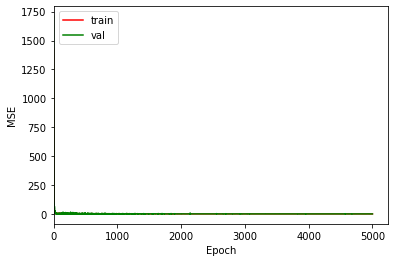

In [9]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('loss_dropoutJLA.png', dpi=100)

In [10]:
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)



In [11]:
pred_random = neural_model2.predict(ranzz)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$

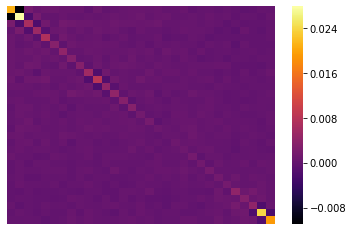

In [12]:
fake_encoded = np.zeros((1, 31))
avg_encoded = np.mean(encoded_imgs, axis=0)
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]
    
decoded_fake = decoder.predict(fake_encoded)
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))

sns.heatmap(pd.DataFrame(decoded_fake.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [13]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [14]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

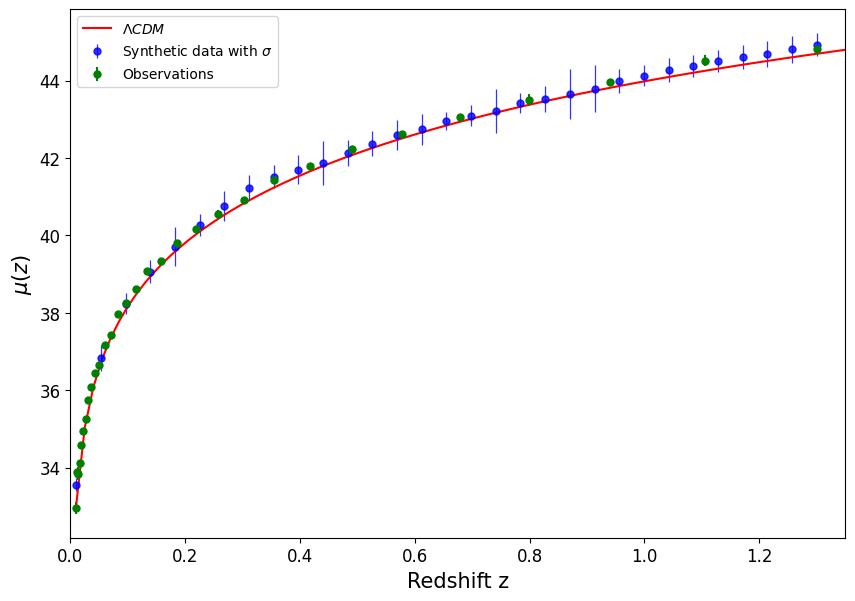

In [15]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)

fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))


sigma = np.sqrt(fakeerrors **2 + std_mc_dropout.reshape(31,))

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift z', fontsize=15)
plt.ylabel('$\mu(z)$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=80)

In [16]:
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

np.savetxt("fake_binned_JLA_COVdecodedDO2.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLADO2.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [17]:
autoencoder.save('autoencoderJLA_DO.h5')
decoder.save('decoderJLA_DO.h5')
neural_model2.save('FFNN_JLA_DO.h5')
encoder.save('encoderJLA_DO.h5')